In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
# Load the microdissection density data
microdissection_density = pd.read_csv('data/MALDI_IHC/microdissection_densities.csv')

# Load the immuno count data
immuno_counts = pd.read_csv('data/MALDI_IHC/results/immuno_counts_selected_vst.csv')

# Load the metadata
metadata = pd.read_csv('data/PDAC_MICRODISSEC_NAIF/rna_seq_metadata.csv', index_col=0)

In [3]:
# Add the slide to the microdissection_density dataframe
microdissection_density['Slide'] = metadata["Idpatient_bloc"].loc[microdissection_density["microdissection"]].values

# Reorder the columns in the microdissection_density dataframe
microdissection_density = microdissection_density[["microdissection", "Slide", "CD8", "Collagen", "Defects", "Lesion", "Stroma", "Tumor"]]

# Rename the microdissection column to match the gene expression data
microdissection_density = microdissection_density.rename(columns={"microdissection": "Microdissection"})

# Add density to the microdissection_density column names
microdissection_density.columns = [f'{col}_density' if col in ["CD8", "Collagen", "Defects", "Lesion", "Stroma", "Tumor"] else col for col in microdissection_density.columns]

# Join the immuno_counts and microdissection_density dataframes on the Microdissection column
immuno_counts_density = microdissection_density.merge(immuno_counts, on='Microdissection')

# Filter the immuno_counts_density to exclude the samples with defects > 0.1
immuno_counts_density = immuno_counts_density[immuno_counts_density["Defects_density"] < 0.1]

# Filter the immuno_counts_density to exclude outside the lesions > 0.1
# immuno_counts_density = immuno_counts_density[immuno_counts_density["Lesion_density"] > 0.5]

# Drop the Defects and Lesion columns
immuno_counts_density = immuno_counts_density.drop(columns=['Defects_density', 'Lesion_density'])

immuno_counts_density.head()

,Microdissection,Slide,CD8_density,Collagen_density,Stroma_density,Tumor_density,Tcells,CD8Tcells,Cytotox.lymph,NK,B.lineage,Mono.lineage,Myeloid.dendritic,Neutrophils,Endothelial,Fibroblasts
0,BPDAC_023_19_L1_S92,12AG01290_19,0.014677,0.215176,0.365648,0.284161,6.739429,7.031813,6.516553,5.635666,7.287451,7.150940,6.354673,7.047871,7.083916,9.787932
1,BPDAC_023_26_L1_S5,12AG01290_26,0.001412,0.250392,0.515779,0.247846,6.343850,6.777122,6.062026,5.409144,7.203697,7.025916,5.955171,7.032242,6.628668,9.982346
2,X0823_012,12AG01290_26,0.001606,0.256233,0.524407,0.247040,5.978248,5.768979,6.042049,5.381286,6.619132,6.673158,5.537443,7.120559,6.447116,9.200919
3,X0823_013,12AG01290_26,0.003378,0.188455,0.528874,0.243212,6.036549,5.558794,6.137360,5.535395,6.839096,7.890355,5.603494,7.398113,6.542527,10.202765
5,BPDAC_029_26_L2_S78,13AG00043_26,0.001849,0.225554,0.648581,0.176459,6.269578,6.702434,6.389697,5.661719,5.959811,8.345492,6.278578,7.389183,6.977594,11.994668


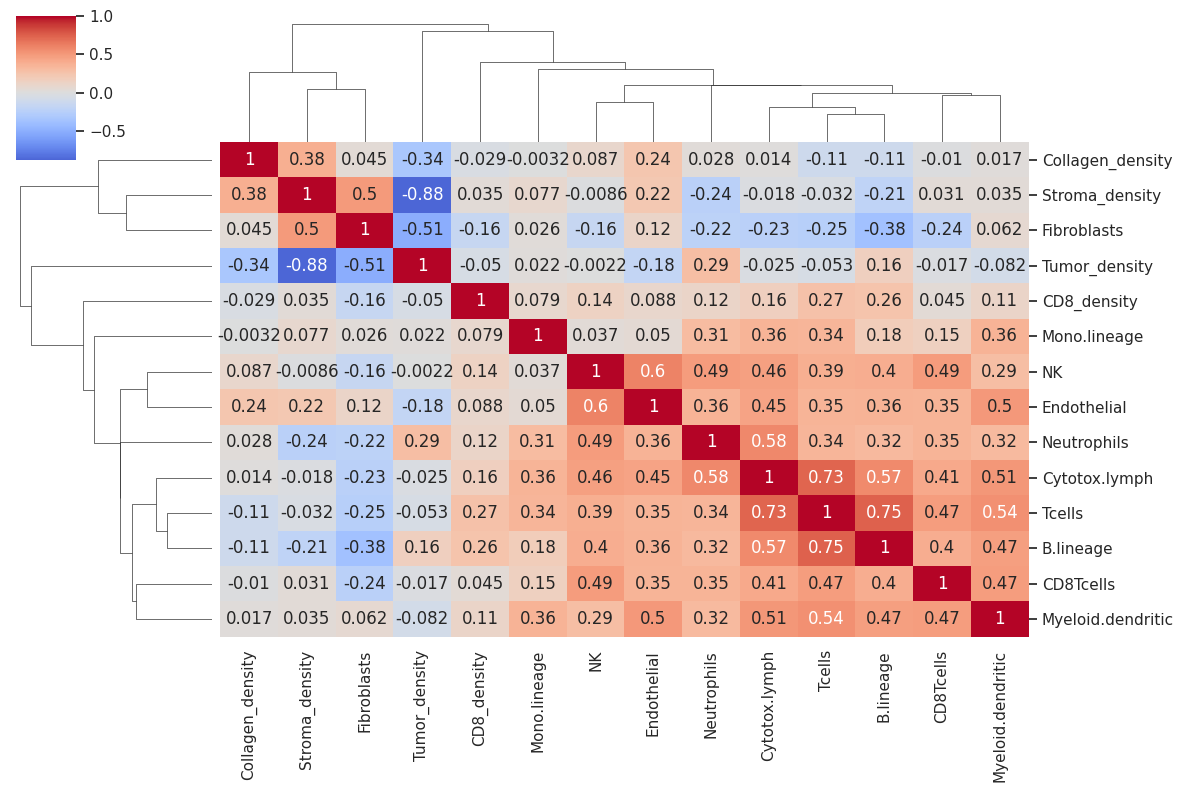

In [4]:
# Find the correlation between all the immuno counts columns and all the microdissection density columns
correlations = immuno_counts_density.iloc[:, 2:].corr()

# plot the clustermap of the correlations
sns.clustermap(correlations, annot=True, cmap='coolwarm', center=0, figsize=(12, 8))
plt.show()

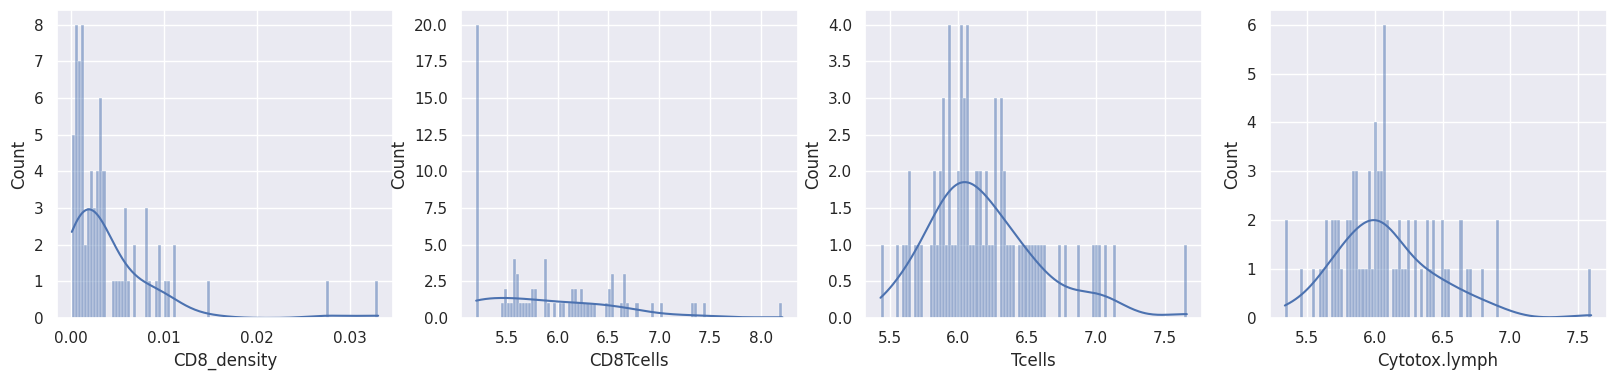

In [5]:
# Plot a histogram of the CD8 density
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
sns.histplot(data=immuno_counts_density, x="CD8_density", bins=100, kde=True, ax=ax[0])
sns.histplot(data=immuno_counts_density, x="CD8Tcells", bins=100, kde=True, ax=ax[1])
sns.histplot(data=immuno_counts_density, x="Tcells", bins=100, kde=True, ax=ax[2])
sns.histplot(data=immuno_counts_density, x="Cytotox.lymph", bins=100, kde=True, ax=ax[3])
plt.show()

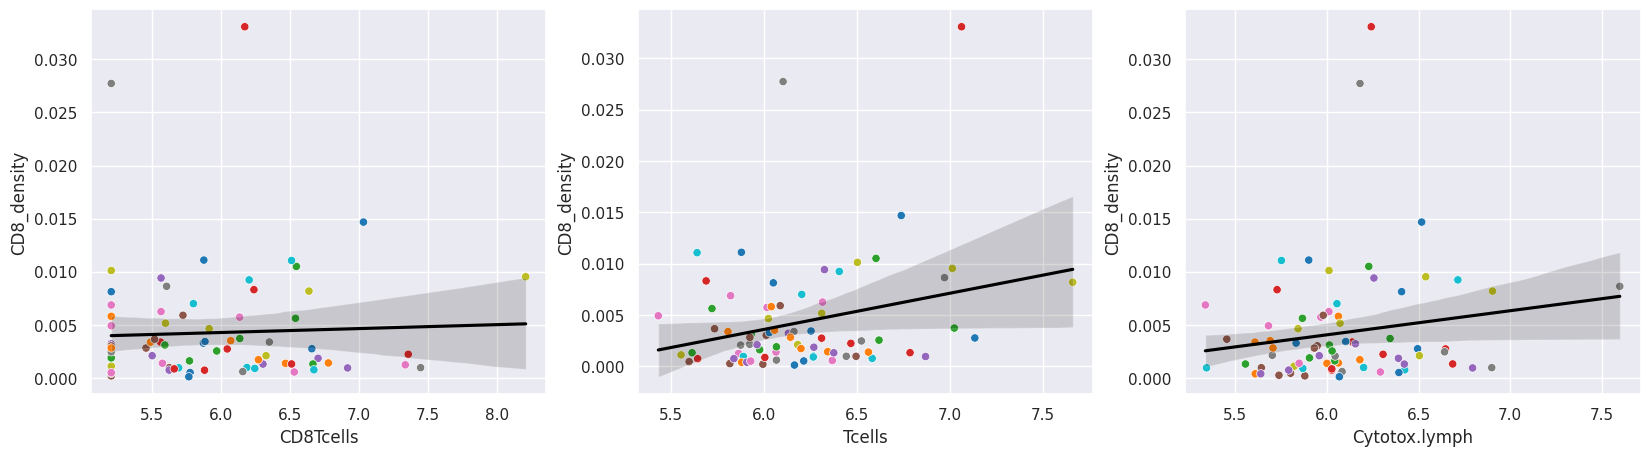

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(x="CD8Tcells", y="CD8_density", data=immuno_counts_density, hue="Microdissection", palette="tab10", ax=ax[0])
sns.scatterplot(x="Tcells", y="CD8_density", data=immuno_counts_density, hue="Microdissection", palette="tab10", ax=ax[1])
sns.scatterplot(x="Cytotox.lymph", y="CD8_density", data=immuno_counts_density, hue="Microdissection", palette="tab10", ax=ax[2])

sns.regplot(x="CD8Tcells", y="CD8_density", data=immuno_counts_density, scatter=False, color='black', ax=ax[0])
sns.regplot(x="Tcells", y="CD8_density", data=immuno_counts_density, scatter=False, color='black', ax=ax[1])
sns.regplot(x="Cytotox.lymph", y="CD8_density", data=immuno_counts_density, scatter=False, color='black', ax=ax[2])

for i in range(3):
    if ax[i].get_legend() is not None:
        ax[i].get_legend().remove()

plt.show()

In [8]:
# Add a column to the immuno_counts_density dataframe to identify the samples with low CD8_density and high CD8Tcells
immuno_counts_density["Desert_CD8"] = (immuno_counts_density["CD8_density"] < 0.002) & (immuno_counts_density["CD8Tcells"] > 5.5)

# Remove only 70% of the samples with CD8_density < 0.005
immuno_counts_density_modified = immuno_counts_density[~immuno_counts_density["Desert_CD8"]]

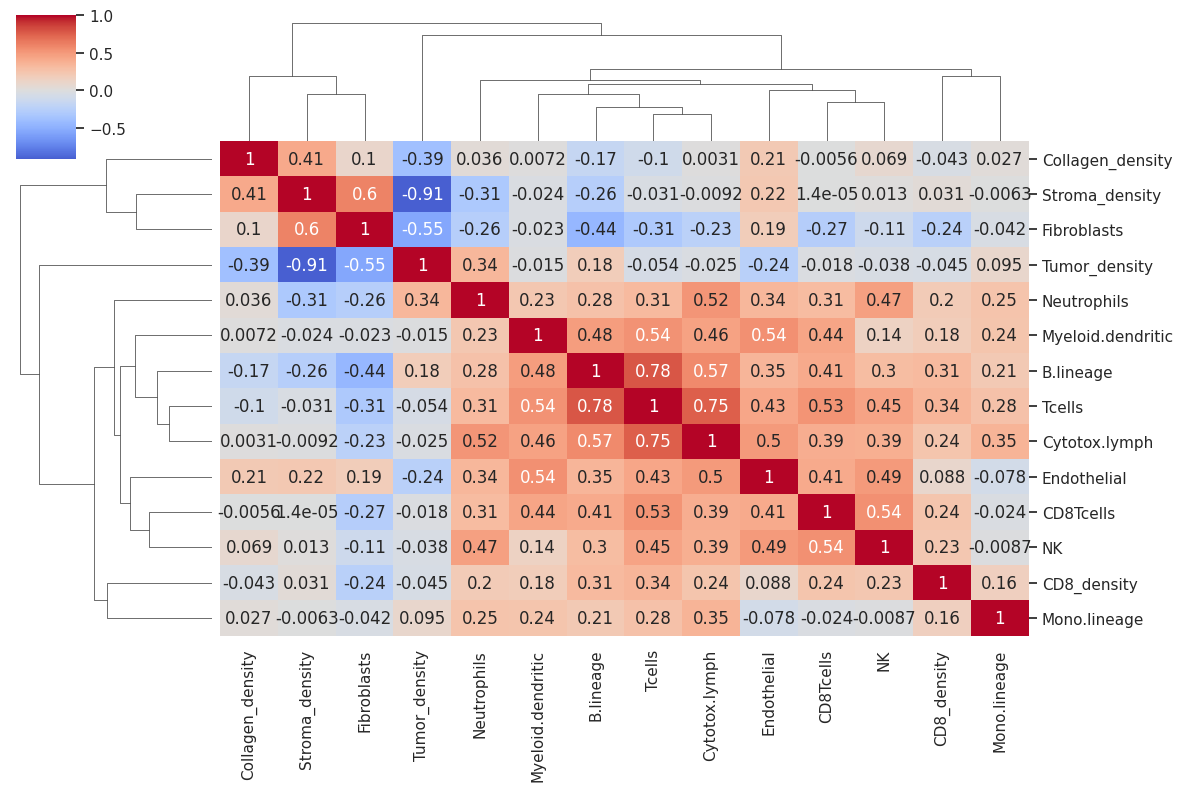

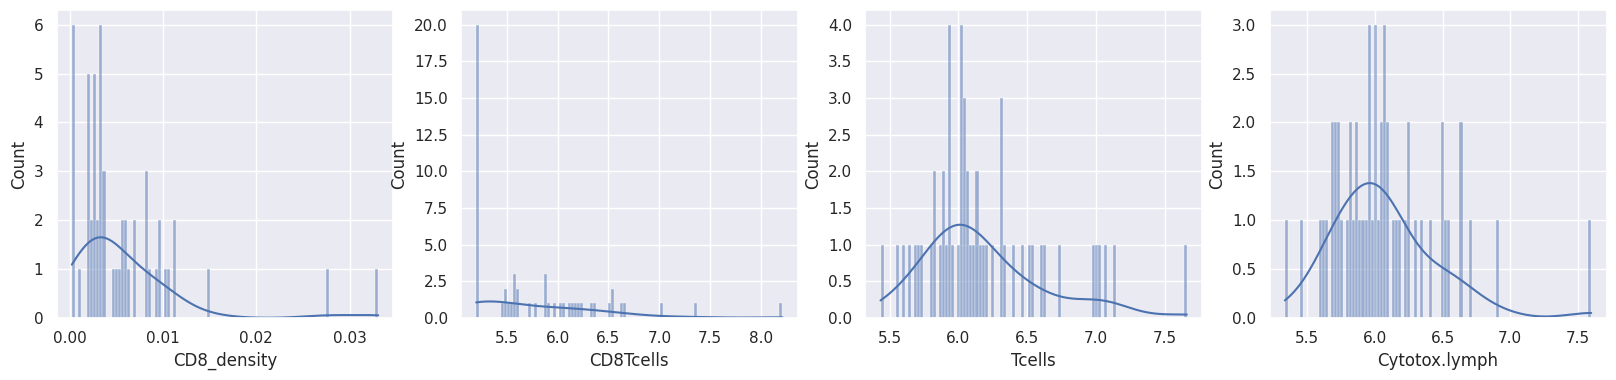

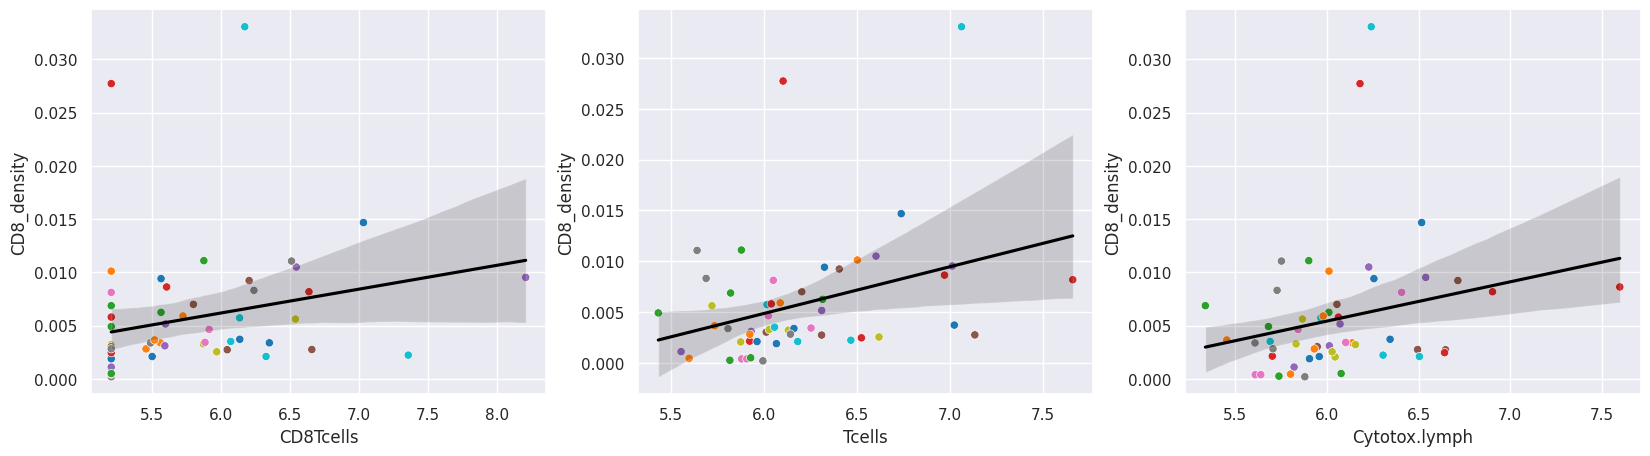

In [9]:
# Find the correlation between all the immuno counts columns and all the microdissection density columns
correlations_modified = immuno_counts_density_modified.iloc[:, 2:-1].corr()

# plot the clustermap of the correlations
sns.clustermap(correlations_modified, annot=True, cmap='coolwarm', center=0, figsize=(12, 8))
plt.show()

# Plot a histogram of the CD8 density
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
sns.histplot(data=immuno_counts_density_modified, x="CD8_density", bins=100, kde=True, ax=ax[0])
sns.histplot(data=immuno_counts_density_modified, x="CD8Tcells", bins=100, kde=True, ax=ax[1])
sns.histplot(data=immuno_counts_density_modified, x="Tcells", bins=100, kde=True, ax=ax[2])
sns.histplot(data=immuno_counts_density_modified, x="Cytotox.lymph", bins=100, kde=True, ax=ax[3])
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(x="CD8Tcells", y="CD8_density", data=immuno_counts_density_modified, hue="Microdissection", palette="tab10", ax=ax[0])
sns.scatterplot(x="Tcells", y="CD8_density", data=immuno_counts_density_modified, hue="Microdissection", palette="tab10", ax=ax[1])
sns.scatterplot(x="Cytotox.lymph", y="CD8_density", data=immuno_counts_density_modified, hue="Microdissection", palette="tab10", ax=ax[2])

sns.regplot(x="CD8Tcells", y="CD8_density", data=immuno_counts_density_modified, scatter=False, color='black', ax=ax[0])
sns.regplot(x="Tcells", y="CD8_density", data=immuno_counts_density_modified, scatter=False, color='black', ax=ax[1])
sns.regplot(x="Cytotox.lymph", y="CD8_density", data=immuno_counts_density_modified, scatter=False, color='black', ax=ax[2])

for i in range(3):
    if ax[i].get_legend() is not None:
        ax[i].get_legend().remove()

plt.show()

In [10]:
# Save the immuno_counts_density dataframe to a csv file
immuno_counts_density_modified.to_csv('data/MALDI_IHC/results/immuno_counts_density.csv', index=False)